# First lets import packgages and generate our data for PureSVD

In [1]:
!pip install --upgrade git+https://github.com/Evfro/polara.git@develop#egg=polara

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Evfro/polara.git (to revision develop) to /tmp/pip-install-m1cpp5i7/polara_cd23c564cd9b4059a07af86f0ac7c3b9
  Running command git clone --filter=blob:none --quiet https://github.com/Evfro/polara.git /tmp/pip-install-m1cpp5i7/polara_cd23c564cd9b4059a07af86f0ac7c3b9
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/Evfro/polara.git to commit 8e48cfd88e616ca53f8bbda1702a3e2c8abaf38e
  Preparing metadata (setup.py) ... done
  Created wheel for polara: filename=polara-0.7.2.dev0-py3-none-any.whl size=89447 sha256=36dea944a4ce3e737ee4f303f46e4c546e842de00efc481ebb62edae338aca56
  Stored in directory: /tmp/pip-ephem-wheel-cache-5_py_a74/wheels/c2/75/e1/1f178798f10150e60b8adfdce7e1cce378d6d6aae728aec5df
Successfull

In [2]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Data_HSVD')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import scipy as sp
from scipy.sparse.linalg import spsolve_triangular
from maxvol import maxvol, maxvol_rect
from dataprep import generate_interactions_matrix, reindex_data, transform_indices, timepoint_split
from hybridSVD import hsvd

In [ ]:
users = ['User1', 'User2', 'User3', 'User4', 'User5', 'User6', 'User7', 'User8', 'User9']
items = ['Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8', 'Item9', 'Item10', 'Item11', 'Item12', 'Item13']
ratings = np.array([[4, 0, 8, 0, 0, 6, 0, 9, 7, 8, 0, 0, 0], 
                   [5, 8, 0, 0, 0, 6, 4, 0, 8, 0, 0, 4, 0], 
                   [0, 4, 5, 0, 0, 0, 8, 8, 7, 9, 8, 0, 0], 
                   [5, 0, 0, 8, 0, 0, 0, 6, 6, 0, 4, 7, 4],
                   [0, 0, 6, 0, 8, 0, 0, 0, 0, 5, 0, 6, 0],
                   [4, 7, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 5], 
                   [0, 0, 0, 9, 9, 0, 6, 0, 0, 0, 3, 5, 0],
                   [0, 6, 5, 0, 5, 4, 7, 6, 0, 0, 0, 6, 0],
                   [0, 0, 0, 0, 0, 5, 0, 7, 7, 6, 8, 0, 6]])

data = pd.DataFrame(ratings, users, items)

In [ ]:
data

,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8,Item9,Item10,Item11,Item12,Item13
User1,4,0,8,0,0,6,0,9,7,8,0,0,0
User2,5,8,0,0,0,6,4,0,8,0,0,4,0
User3,0,4,5,0,0,0,8,8,7,9,8,0,0
User4,5,0,0,8,0,0,0,6,6,0,4,7,4
User5,0,0,6,0,8,0,0,0,0,5,0,6,0
User6,4,7,0,0,8,0,0,0,0,0,0,0,5
User7,0,0,0,9,9,0,6,0,0,0,3,5,0
User8,0,6,5,0,5,4,7,6,0,0,0,6,0
User9,0,0,0,0,0,5,0,7,7,6,8,0,6


# SVD. Why and when PureSVD does not work?

The meaning of SVD is that we can decompose a rectangular matrix (interaction) $A$ into 3 matrices: $U$, $Σ$, and $V$.
$$A_{m \times n} = U_{m \times m} \Sigma_{m \times n} V_{n \times n}^T$$
Here, $U$ is an $m \times m$ orthogonal matrix, $V$ is an $n \times n$ orthogonal matrix, and $Σ$ is an $m \times n$ diagonal matrix. The diagonal elements of $Σ$ are ordered $λ_1 ≥ λ_2 ≥ ... ≥ λ_k ≥ 0$ for $k = min(m, n)$.

In the case of a sparse matrix, which is often the case for movie ratings, we can use a truncated SVD, where we keep only the first $d$ singular values $λ$. This results in a decomposition of the matrix $A'$, which provides a good approximation to the original matrix $A$.
$$A_{m \times n} = U_{m \times d} \Sigma_{d \times d} V_{d \times n}^T$$

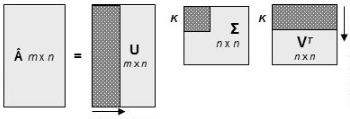

Now let's apply this to our recommendation system. We have a interaction matrix $R$, so let's perform its singular value decomposition.

Using the truncated SVD, we can express the matrix R as:

$$R_{m \times n} = U_{m \times d} \Sigma_{d \times d} V_{d \times n}^T$$

where $U$ is an $m \times d$ orthogonal matrix, $V$ is a $d \times n$ orthogonal matrix, and $Σ$ is a $d \times d$ diagonal matrix containing the first $d$ singular values of interaction matrix $R$.

We can then multiply the first two matrices to obtain an $n \times d$ matrix, resulting in the following decomposition:

$$R_{m \times n} \approx U_{m \times d} \Sigma_{d \times d} V_{d \times n}^T = P_{m \times d} Q_{d \times n}^T$$

where $P$ represents the user-feature matrix and $Q$ represents the item-feature matrix. The $d$ columns of $P$ and $Q$ represent the latent features that capture the important relationships between the users and items.

This decomposition allows us to make predictions for user-item pairs that are not in the original ratings matrix by estimating their ratings based on the dot product of the corresponding rows in $P$ and $Q$. The truncated SVD can help us identify the most important features for making these predictions, and can also help us deal with the sparsity of the ratings matrix.

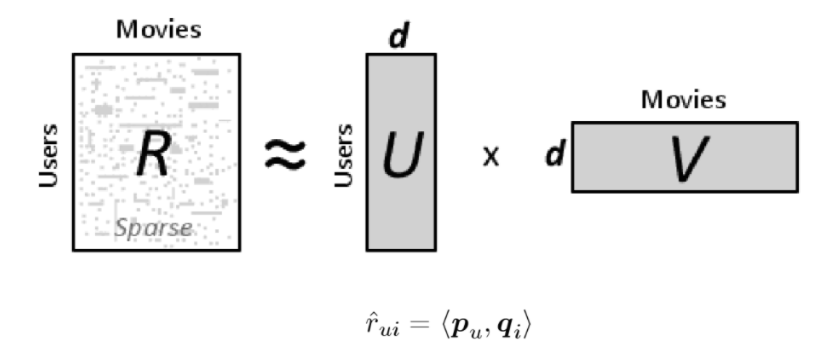

The dimension of $d$ in this case represents the number of hidden properties/interests of our users and movies, and the predicted rating $\hat r_{ui}$ for a movie is obtained by taking the dot product of the corresponding rows of the $U$ and $V$ matrices.

Therefore, we have learned how to approximate the original ratings matrix using a matrix obtained from the multiplication of two matrices that correspond to the interests of users and properties of movies. However, the problem is that our ratings matrix R is sparse, and we would like to fill in the empty (zero) elements with ratings from users.

To achieve this, we need to approximate the existing ratings as numbers obtained from the multiplication of the matrices $U$ and $V$. Then, we can obtain the ratings for the zeros in our original matrix and minimize the following function:

$$ \large \hat r_{ui} = <p_u,q_i>$$

$$\mathcal{L} = \large \frac{1}{n}\sum_{ui} (r_{ui}-\hat r_{ui})^{2} = \frac{1}{n}\sum_{ui} (r_{ui} -<p_u,q_i>)^{2} \to \operatorname{min},$$

where the sums are taken over the nonzero indices $u, i$ of our original ratings matrix, and $n$ is the total number of ratings in the matrix.

This is the least squares problem, and we can solve it efficiently using gradient descent or alternating least squares (ALS) algorithms. The goal is to find the optimal values of $P$ and $Q$ that minimize the loss function and provide the best possible approximation to the original matrix $R$.

We need to add regularization to our loss function to prevent overfitting. We can use L2 regularization to constrain the norm of our matrices:

$$\large \lambda(\Sigma_{u}p {\tiny u}^{2} + \Sigma_{i}q {\tiny i}^{2})$$

Thus, our new loss function is:

$$\mathcal{L} = \large \frac{1}{n}\sum_{ui} (r_{ui} - <p_u,q_i>)^{2} + \lambda(\Sigma_{u}p {\tiny u}^{2} + \Sigma_{i}q {\tiny i}^{2}) \to \min,$$

To minimize this function using stochastic gradient descent, we need to compute the gradients for the $P$ and $Q$ matrices. We can calculate the gradients on a single object from the ratings matrix. The update rules for the elements of the $U$ and $V$ matrices are:

$$\large p {\tiny u,k} = p {\tiny u,k} -\alpha \frac{\partial L}{\partial p {\tiny u,k}} = p {\tiny u,k}+\alpha e {\tiny u,i} q_{k} - \lambda p {\tiny u,k}$$

$$\large q {\tiny i,k} = q {\tiny i,k}-\alpha \frac{\partial L}{\partial q {\tiny i,k}} = q {\tiny i,k}+\alpha e {\tiny u,i} p_{k} - \lambda q_{\tiny i,k}$$

Here, $e_{ui}$ is the error between the predicted rating and actual rating of the $(u,i)$ pair, $α$ is the learning rate, and $λ$ is the regularization parameter. We can update the elements of the matrices iteratively until we reach the minimum of our loss function.

Indices $u,i$ - number of users and items **U** (number rows) и **V** (number columns), $j$ - $j^{th}$ component of $\large p_{u}$ and $\large q_{i}$.

Lets implement this function:

In [29]:
from tqdm.autonotebook import tqdm
def SVD(R, d, step, lambda_reg, n_iters):
  U = np.zeros((R.shape[0],d))
  V = np.zeros((d,R.shape[1]))

  mu = R.sum()/(R!=0).sum()
  non_zero = (R!=0).sum()
  U = U + mu
  V = V + mu

  indx=[]
  zero_indx = []
  MSE_start = 0
  MSE=[]
  for i in tqdm(range(R.shape[0])):
    for j in range(R.shape[1]):
      if R[i][j]>0:
        indx.append([i,j])
        MSE_start+=((R[i, j]-np.dot(U[i,:],V[:,j]))** 2) / non_zero
      else:
        zero_indx.append([i, j])
  for n in range(n_iters): # Gradients
    choice = np.random.randint(0,len(indx))
    ij = indx[choice]
    for k in range(0,d):
      U[ij[0],k] = U[ij[0],k] + step * ((R[ij[0]][ij[1]] - np.dot(U[ij[0], :], V[:,ij[1]])) * V[k,ij[1]] - lambda_reg * U[ij[0],k])
      V[k,ij[1]] = V[k,ij[1]] + step * ((R[ij[0]][ij[1]] - np.dot(U[ij[0], :], V[:,ij[1]])) * U[ij[0],k] - lambda_reg * V[k,ij[1]])
    L=0
    for i in range(R.shape[0]):
      for j in range(R.shape[1]):
        if R[i, j]>0:
          L+=((R[i, j]-np.dot(U[i,:],V[:, j])) ** 2)/non_zero
    MSE.append(L)
  return U,V, MSE_start, MSE

In [ ]:
U, V, M1, M_end = SVD(data.values, 4, 1e-3, 0.1, 20000)

In [ ]:
M_end[-1]

1.0705853519323163

In [ ]:
data.index

Index(['User1', 'User2', 'User3', 'User4', 'User5', 'User6', 'User7', 'User8',
       'User9'],
      dtype='object')

In [ ]:
r_cap = np.zeros((data.shape[0], data.shape[1]))
for i in range(data.shape[0]):
  for j in range(data.shape[1]):
    r_cap[i, j] = np.dot(U[i, :], V[:, j])

In [ ]:
rec = pd.DataFrame(r_cap, users, items)

In [ ]:
rec

,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8,Item9,Item10,Item11,Item12,Item13
User1,5.304426,7.333922,6.877470,10.794738,8.890005,6.232497,8.362056,8.153690,7.872014,7.885966,7.315352,7.139344,6.523332
User2,4.910576,7.378990,6.052135,9.055016,7.228770,6.022295,7.299342,5.794415,6.817785,5.793931,5.956120,5.030094,5.901172
User3,4.312373,5.408612,5.886744,9.656944,8.167556,4.829692,7.213069,8.275822,6.840893,7.825863,6.713569,7.287117,5.432725
User4,3.885183,5.356653,5.045452,7.930551,6.537286,4.558340,6.135740,6.017427,5.777921,5.814748,5.378795,5.270064,4.781401
User5,4.853901,7.137457,6.065691,9.199253,7.410644,5.885903,7.332407,6.192311,6.863583,6.126392,6.103840,5.390457,5.869650
User6,4.544447,6.562229,5.743142,8.804040,7.142324,5.459149,6.954974,6.155142,6.521783,6.042961,5.881044,5.368799,5.523521
User7,4.324681,6.238681,5.468777,8.388242,6.807700,5.192383,6.623134,5.876355,6.211441,5.766812,5.605187,5.126224,5.257812
User8,4.015807,5.589598,5.186832,8.113018,6.667148,4.734319,6.302545,6.062201,5.929992,5.875026,5.486518,5.305353,4.929840
User9,4.798401,6.836820,6.113236,9.442598,7.697823,5.724781,7.412696,6.773042,6.959603,6.615982,6.337199,5.915455,5.853727


**Why and when PureSVD not works**

As we can see from the examples, the standard SVD does not take into account the relationships between movies or users. For example, in our first case using SVD, we need to recommend User9 from these movies: Item1, Item2, Item3, Item4, Item5 and add additional information that Item3 and Item11 are similar in genre. As we can see from the results, the model did not take this into account, only considering the relationship between item/user. HybridSVD takes this into account.

# Example from paper (HybridSVD: When Collaborative Information is Not Enough)

In [ ]:
us = ['Alice', 'Bob', 'Carol', 'Tom']
it = ['item1', 'item2', 'item3', 'item4', 'item5']
inte = np.array([[1, 0, 1, 1, 0], [1, 1, 0, 1, 0], [1, 0, 0, 1, 0], [1, 0, 0, 1, 1]])
ss = pd.DataFrame(inte, us, it)
ss

,item1,item2,item3,item4,item5
Alice,1,0,1,1,0
Bob,1,1,0,1,0
Carol,1,0,0,1,0
Tom,1,0,0,1,1


In [ ]:
U_1, V_1, M_s, M_e = SVD(ss.values, 2, 1e-3, 0.01, 10000)

In [ ]:
r_cap = np.zeros((ss.shape[0], ss.shape[1]))
for i in range(ss.shape[0]):
  for j in range(ss.shape[1]):
    r_cap[i, j] = np.dot(U_1[i, :], V_1[:, j])

In [ ]:
r_cap

array([[0.95053437, 1.089483  , 1.08248368, 0.94835773, 1.09408109],
       [0.94692147, 1.08534196, 1.07836925, 0.94475311, 1.08992258],
       [1.0527914 , 1.20668794, 1.19893565, 1.0503806 , 1.21178069],
       [0.94688458, 1.08529968, 1.07832724, 0.9447163 , 1.08988012]])

In [ ]:
# rating matrix
a = np.array([[1, 0, 1, 1, 0],
              [1, 1, 0, 1, 0],
              [1, 0, 0, 1, 0]])

# vector of a new user's preferences
p = np.array([1, 0, 0, 1, 1])

# ========== Standard Model ==========

rank = 2
u, s, vt = np.linalg.svd(a, full_matrices=False)
v = vt.T[:, :rank]

# recommendations for the user with standard folding-in approach
recs = p.dot(v).dot(v.T)
recs

array([0.8904344 , 0.31234752, 0.31234752, 0.8904344 , 0.        ])

In [5]:
ratings = pd.read_csv('/content/drive/MyDrive/Data_HSVD/ratings.dat', sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies = pd.read_csv('/content/drive/MyDrive/Data_HSVD/movies.dat', sep='::',names=['movieid', 'title', 'genres'],
                              encoding='ascii',encoding_errors='replace')
users = pd.read_csv('/content/drive/MyDrive/Data_HSVD/users.dat', sep='::', names=['userid', 'gender', 'age', 'occupation', 'zip-code'])

<ipython-input-5-aeabab525178>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('/content/drive/MyDrive/Data_HSVD/ratings.dat', sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
<ipython-input-5-aeabab525178>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv('/content/drive/MyDrive/Data_HSVD/movies.dat', sep='::',names=['movieid', 'title', 'genres'],
<ipython-input-5-aeabab525178>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted

In [7]:
print(ratings.shape)
ratings.head()

(1000209, 4)


,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [21]:
ratings.rating.max()

5

In [8]:
print(movies.shape)
movies.head()

(3883, 3)


,movieid,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
print(users.shape)
users.head()

(6040, 5)


,userid,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


# Preprocessing

First, we create a set of binary features for each genre. The purpose of this preprocessing step is to convert categorical data (i.e., movie genres) into numerical features that can be used as input to machine learning algorithms. By creating binary feature columns for each genre, we can represent each movie as a vector of $0$'s and $1$'s indicating which genres it belongs to. We have matrix $F_I$ with size $n\_genres \times n\_movies$. \\

In [6]:
#encode genres
movies['genres'] = movies['genres'].apply(lambda x: str(x).split('|'))
all_genres = set(list(movies['genres'].sum()))
for genre in all_genres:
    movies[genre] = movies['genres'].apply(lambda x: genre in x).astype(int)

In [7]:
movies.head()

,movieid,title,genres,Fantasy,Romance,Mystery,Adventure,Comedy,Drama,Thriller,...,Horror,Musical,Western,Animation,Sci-Fi,Film-Noir,Crime,Action,Documentary,Children's
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Also we will preprocess users data. This preprocessing step is to convert categorical data (i.e., user occupations, ages, and genders) into numerical features. By creating binary feature columns for each occupation, age group, and gender, we can represent each user as a vector of $0$'s and $1$'s indicating their demographic characteristics. Here we have seven different ages and we will use this number for user features. This can be useful for building recommendation models that take into account user preferences based on these characteristics. We have matrix $F_U$ with size $n\_users \times n\_occupations + n\_ages$

In [8]:
occupations_dict = {
    0:  "other",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10:  "K-12 student",
    11:  "lawyer",
    12:  "programmer",
    13:  "retired",
    14:  "sales/marketing",
    15:  "scientist",
    16:  "self-employed",
    17:  "technician/engineer",
    18:  "tradesman/craftsman",
    19:  "unemployed",
    20:  "writer"
}
users['occupation'] = users['occupation'].apply(lambda x: occupations_dict[x])
occupations_dummies = pd.get_dummies(users['occupation'])
age_dummies = pd.get_dummies(users['age'],prefix='age')
users['gender'] = users['gender'].apply(lambda x: 1 if x=='M' else 0)
users = pd.concat([users, occupations_dummies, age_dummies], axis=1)

In [9]:
print(users.shape)
users.head()

(6040, 33)


,userid,gender,age,occupation,zip-code,K-12 student,academic/educator,artist,clerical/admin,college/grad student,...,tradesman/craftsman,unemployed,writer,age_1,age_18,age_25,age_35,age_45,age_50,age_56
0,1,0,1,K-12 student,48067,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2,1,56,self-employed,70072,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,1,25,scientist,55117,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,1,45,executive/managerial,02460,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5,1,25,writer,55455,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


# Split and re-index data

Next step we will split the `ratings` dataframe into training, test, and holdout sets based on a time-based split, and then re-index the resulting dataframes to ensure that user and item IDs are contiguous integers starting from 0. More precisely, the split is performed based on the `timestamp` column of `data`, using `time_split_q` as the quantile value (in our case it is $99\%$). The `holdout` dataset contains only the immediate interactions following the fixed timepoint for each test user from the `testset`. The set of users in `training` is disjoint with the set of users in the `testset`, which implements the $\textbf{warm-start}$ scenario.

In [10]:
training_ , testset_ , holdout_ = timepoint_split(ratings, time_split_q=0.99)
training , data_index = transform_indices(training_ , 'userid', 'movieid')
testset = reindex_data(testset_, data_index, fields='items')
holdout = reindex_data(holdout_, data_index, fields='items')
testset = testset.query('userid >= 0')
training.shape, testset.shape, holdout.shape

((858241, 4), (131944, 4), (347, 4))

In [11]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    user_index = data_index['users'],
    item_index = data_index['items']
)

# Build Side Features Matrix

Here we will build side feature matrices for the movie and user data. First, we create a `movie_features` dataframe that contains all columns from the `movies` dataframe except for the `title` and `genres` columns after re-indexing. Next, we extract all columns from the second column onwards (i.e., all feature columns) of the sorted `movie_features` dataframe, convert them to a numpy array of float values, and transpose the resulting array such that each row represents a feature and each column represents an item. This creates a side feature matrix $F_I$ for the movie data.

In [12]:
movie_features_ = movies.drop(['title', 'genres'],axis=1)
movie_features = reindex_data(movie_features_, data_index, fields='items')
movie_features = movie_features.query('movieid >= 0').sort_values(by='movieid')
item_features_mtx = movie_features.iloc[:,1:].values.astype(float).T
item_features_mtx.shape

(18, 3687)

For the user data, we create a new dataframe that contains all columns from the `users` dataframe except for `age`, `occupation`, and `zip-code` after re-indexing. Last, we extract all columns from the second column onwards (i.e., all feature columns) of the re-indexed user dataframe, convert them to a numpy array of float values, and store them in another side feature matrix $F_U$ for user data.

In [13]:
user_features_ = users.drop(['age', 'occupation', 'zip-code'], axis=1)
user_features = reindex_data(user_features_, data_index, fields='users')
user_features = user_features.query('userid >= 0')
user_features_mtx = user_features.iloc[:,1:].values.astype(float)
user_features_mtx.shape

(5692, 29)

# What is HybridSVD?

Lets assume $S$ - is matrix relations item/item. It may conclude genres for example. If in our case we have $N$ items (movies) matrix $S_{N \times N}$. Similarly for users $K_{M \times M}$ matrix is conclude relations users/user. For example, users may work in same sphere or users has same ages and etc. We will use this matrices *side similarity*. 

A **latent feature space** refers to a lower-dimensional space in which users and items are represented as points (or vectors) with respect to some set of underlying features or attributes. These features or attributes are not directly observable, but are inferred from the patterns of user-item interactions in the data.

The idea behind using a latent feature space is to capture the underlying structure of the user-item interactions in a more compact and interpretable way. By representing users and items as points in this lower-dimensional space, we can more easily identify patterns and similarities between them that might not be apparent in the original high-dimensional space.

For example, if we have an item that is frequently purchased by young male customers who also tend to buy sports equipment, its embedding might be close to other items that are popular among similar customers (e.g., other sports equipment or clothing items). Similarly, if we have a user who frequently purchases items related to cooking and baking, their embedding might be close to other users who share similar interests.

The number of dimensions in the latent feature space is typically much smaller than the number of dimensions in the original high-dimensional space (e.g., hundreds or thousands vs. millions), which makes it easier to learn and interpret meaningful patterns from the data.

As relations item/item and user/user not include in $RR^T$ (relations users with similar items) or $R^TR$ (relations items with similar users) for all users and all items generates the following matrix cross-products (*Matrix cross-products refer to the products of matrices that are formed by taking the product of a matrix with its transpose*): $RSR^T, R^TR$, where $R$ is the same as in PureSVD. 

By analogy with standard SVD, this induces the following eigendecomposition problem: $$RSR^T = U \Sigma^2 U^T \ \ \ \ \ \ (\text{user to user, including information relation between items}), $$ $$R^TKR = V \Sigma V^T \ \ \ \ \ \ (\text{item to item, including information relation between users})$$ 

where, matrices $U \in R^{M \times k}$ and $V \in R^{N \times k}$ represent embeddings (*embeddings refer to low-dimensional representations of users and items in a latent feature space. These embeddings are learned by factorizing a user-item interaction matrix (or a related matrix) into two lower-dimensional matrices that represent the embeddings of users and items, respectively*) of users and items onto a common $k$-dimensional latent feature space.

Here, this decomposition is obtained as a result of the standard singular value decomposition. We begin by defining an auxiliary matrix $\hat{R}$ as:
$$\hat{R} = K^{\frac{1}{2}}RS^{\frac{1}{2}}$$
Then we compute the standard singular value decomposition as $\hat{R}$ as:
$$\hat{R} = \hat{U} \Sigma \hat{V}^T$$
Here, $\hat{U}, \Sigma, \hat{V}$ represent singular triplets of matrix $\hat{R}$

Connections between original (i.e. matrices of the generalized eigenvectors) and auxiliary latent space for both users and items are $U = K^{\frac{1}{2}} \hat{U}$ and $V = S^{\frac{1}{2}} \hat{V}$ respectively.

Assume that, $K, S$ are symmetric positive definite (for example, item/item relations may be symmetric, because if item1 and item2 has same genres, also item2 and item1 is too same genres). We can represent this matrices in the *Cholesky decomposition* as:
$$S = L_SL_S^T, \ K = L_KL_K^T$$
here, $L_S, L_K$ - are lower triangular real matrices. Using this representations it can be verified that the following auxiliary matrix
$$\hat{R} = L_K^TRL_S = \hat{U} \Sigma \hat{V}^T$$
Also connections between original and auxiliary latent space for both users and items are $U = L_K^{-T}\hat{U}, \ V = L_S^{-T}\hat{V}.$

As we can see matrix $\hat{R}$ has additional relations encoded by $K$ and $S$ simultaneusly. From this, solving system of eqautions is get to finding standart SVD of auxilary matrix. This model called $\text{HybridSVD.}$

We note that, columns of the matrices $U$ and $V$ are orthogonal under the constrains imposed by the matrices $K$ and $S$ respectively.  

To improve the quality of collaborative models, $K, S$ matrices must capture representative structure from side information. For $Z$ and $Y$ real symmetric matrices, that can forming size with enteries encoding actual feature-based similarities and taking values in interval $[ -1, 1 ],$ and $\alpha, \beta \in [0, 1]$ coefficients, that changes the balance between collaborative and side information we impose the following structure in them:
$$S = (1-\alpha)I + \alpha Z,$$ $$K = (1-\beta)I + \beta Y$$

Note that, in case $\alpha = \beta = 0$ model turns back into PureSVD. On the other extreme when $\alpha = \beta = 1$ model would heavily rely on feature-based similarities, which can be an undersired behavior. 

In our hypothesis, we explore one of the most direct possible approaches for constructing similarity matrices. We transform movie genre into one-hot encoded vectors and compute the Common Neigbors similarity scaled by a normaliztion constant. More specifically, in movies we form a sparse binary matrix $F_I \in B^{movies \times features}$ which rows are one-hot features (genres) vectors: for example if movie_id: 75 has genre "Comedy", then the corresponding entry in the row is 1, otherwise 0.

# Maximum Volume (maxvol) algorithm

Here we have two functions: 

`maxvol` - computes the maximal-volume submatrix for given tall matrix. This function inputs tall matrix of the shape $n \times r,  (n > r)$. And returns, the row numbers $i$ containing the maximal volume submatrix in the form of 1D array of length $r$ and coefficient matrix $B$ in the form of 2D array of shape $n \times r$, such that $A = B A[i, :]$ and $A (A[i, :])^{-1} = B$. 

`maxvol_rect` - computes the maximal-volume rectangular submatrix for given tall matrix like `maxvol`. Within the framework of this function, the original maxvol algorithm is first called (see function maxvol). Then additional rows of the matrix are greedily added until the maximum allowed number is reached or until convergence.

In [14]:
A = generate_interactions_matrix(training, data_description)

In [15]:
A.A

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0]])

In [38]:
A.shape

(5692, 3687)

In [ ]:
Z2 = (1 / (A.T @ A).max()) * A.T @ A
U2, s2 = hsvd(item_features_mtx, right_similarity=Z2, beta = beta, ret='left')
importance2, _ = maxvol_rect(U2[:-1,:].T, dr_min=1)
hr2, mrr2, cov2 = test_hypo(config1, importance2)

plt.plot(hr2,label='HR@10')
plt.plot(mrr2, label='MRR@10')
plt.xlabel('number of features')
plt.xticks(np.arange(0, len(importance)+1))
# plt.yticks(np.arange(0, 0.007, 0.0008))
plt.legend()

In [ ]:
S_U = cosine_similarity(user_features_mtx,dense_output=False)
# S_U.setdiag(0)
np.fill_diagonal(S_U, 0)
S_U

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.33333333, ..., 0.40824829, 0.        ,
        0.33333333],
       [0.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.66666667],
       ...,
       [0.        , 0.40824829, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33333333, 0.66666667, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
from scipy.linalg import cholesky

def hsvd(source_mtx, rank=None, left_similarity=None, right_similarity=None, alpha=0, beta=0, ret='both'):
    R = source_mtx
    if not left_similarity is None:
        assert left_similarity.shape[0] == left_similarity.shape[1], 'Similarity must be square'
        assert left_similarity.shape[0] == source_mtx.shape[0]
        left_similarity_weighted = (1-alpha) * np.eye(left_similarity.shape[0]) + alpha * left_similarity
        left_cholesky_factor = cholesky(left_similarity_weighted)
        R = left_cholesky_factor.T @ R
    if not right_similarity is None:
        assert right_similarity.shape[0] == right_similarity.shape[1], 'Similarity must be square'
        assert right_similarity.shape[0] == source_mtx.shape[1]
        right_similarity_weighted = (1-beta) * np.eye(right_similarity.shape[0]) + beta * right_similarity
        right_cholesky_factor = cholesky(right_similarity_weighted)
        R = R @ right_cholesky_factor

    U_ , S , V_ = np.linalg.svd(R)
    if not left_similarity is None:
        U = np.linalg.inv(left_cholesky_factor).T @ U_
    else:
        U = U_
    if not right_similarity is None:
        V = V_ @ scipy.linalg.inv(right_cholesky_factor).T
    else:
        V = V_
    
    if ret=='left':
        U = np.ascontiguousarray(U[:,:rank])
        return U, S
    if ret == 'right':
        V = np.ascontiguousarray(V.T[:,:rank])
        return S, V
    if ret == 'both':
        U = np.ascontiguousarray(U[:,:rank])
        V = np.ascontiguousarray(V.T[:,:rank])
        return U, S, V

In [36]:
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from evaluation import topn_recommendations, topidx, downvote_seen_items
def hsvd_svd_recs(item_factors, testset, testset_description, topn = 10):
    recs = {} 
    gp = testset.groupby(testset_description['users'])[
        testset_description['items'],testset_description['feedback']
        ].agg(list)
    for userid, items, ratings in gp.itertuples(name=None):
        ratings = np.array(ratings)
        rated_items = ratings.dot(item_factors[items])
        scores = item_factors.dot(rated_items)
        scores[items] = scores.min() - 1
        # print(scores.shape)
        idx = topidx(scores, topn)
        recs[userid] = list(testset_description['user_index'][idx])
    return recs

In [78]:
def model_evaluate(recommended_users, holdout, holdout_description, topn=10):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    assert recommended_users.shape[0] == len(holdout_items)
    hits_mask = recommended_users[:, :topn] == holdout_items.reshape(-1, 1)
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    # MRR calculation
    n_test_users = recommended_users.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_users
    # coverage calculation
    n_users = holdout_description['n_users']
    cov = np.unique(recommended_users).size / n_users
    return hr, mrr, cov

In [79]:
def test_hypo(config, h_importance, topn = 10):
    rank = config['rank']
    beta = config['beta']
    n_F = len(h_importance)
    hr = np.empty((n_F+1))
    mrr = np.empty((n_F+1))
    cov = np.empty((n_F+1))

    # _, item_factors = hsvd(A.A, rank=-1, ret='right', beta=beta)
    _, item_factors = hsvd(A.A, rank=rank, right_similarity=np.eye(A.shape[1]), beta=beta, ret='right')
    recs = hsvd_svd_recs(item_factors, testset, data_description, topn)
    recommended_items = np.array(list(recs.values()))
    hr[0], mrr[0], cov[0] = model_evaluate(recommended_items, holdout, data_description, topn) # holdout

    for i in tqdm(range(1,n_F+1)):
        F_I = item_features_mtx[h_importance[:i],:]
        S_F = cosine_similarity(F_I.T, dense_output=True)
        np.fill_diagonal(S_F, 0)
        _, item_factors = hsvd(A.A, rank=rank, right_similarity=S_F, beta=beta, ret='right')
        recs = hsvd_svd_recs(item_factors, testset, data_description, topn)
        recommended_items = np.array(list(recs.values()))
        hr[i], mrr[i], cov[i] = model_evaluate(recommended_items, holdout, data_description, topn) # holdout
        # print(mrr)
    return hr, mrr, cov

In [80]:
config1 = dict(
    rank = 100,
    beta = 0.2,
    alpha = 0.2
)
beta = 0.2
alpha = 0.2

In [71]:
# alpha = 0
Z = A.T @ A
S_I = (1 - beta) * np.eye(Z.shape[0]) + (beta / Z.max()) * Z
L_I = cholesky(S_I)
R_ = item_features_mtx @ L_I
U, V, m, n = SVD(R_, 18, 1e-3, 0.1, 200) 

100%|██████████| 18/18 [00:00<00:00, 41.33it/s]


In [72]:
from scipy.linalg import cholesky
L_I = cholesky(S_I)
R_ = item_features_mtx @ L_I
U, V, m, n = SVD(R_, 18, 1e-3, 0.1, 200) 

100%|██████████| 18/18 [00:00<00:00, 43.92it/s]


In [73]:
U.shape

(18, 18)

In [74]:
importance, _ = maxvol_rect(U[:-1,:].T,dr_min=1)

In [75]:
import zipfile
import numpy as np
import pandas as pd
from scipy.sparse import diags
from scipy.sparse.linalg import svds
from tqdm import tqdm
from dataprep import transform_indices, reindex_data, generate_interactions_matrix
from evaluation import downvote_seen_items, topn_recommendations
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds, LinearOperator
from scipy.linalg import cholesky
from polara import get_movielens_data
from polara.preprocessing.dataframes import leave_one_out, reindex
from dataprep import transform_indices
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items

def hsvd(source_mtx, rank, left_similarity=None, right_similarity=None, alpha=0, beta=0, ret='both'):
    R = source_mtx
    if left_similarity is not None:
        assert left_similarity.shape[0] == left_similarity.shape[1], 'Similarity must be square'
        assert left_similarity.shape[0] == source_mtx.shape[0]
        left_similarity_weighted = (1-alpha) * np.eye(left_similarity.shape[0]) + alpha * left_similarity
        left_cholesky_factor = cholesky(left_similarity_weighted)
        R = left_cholesky_factor.T @ R
    if right_similarity is not None:
        assert right_similarity.shape[0] == right_similarity.shape[1], 'Similarity must be square'
        assert right_similarity.shape[0] == source_mtx.shape[1]
        right_similarity_weighted = (1-beta) * np.eye(right_similarity.shape[0]) + beta * right_similarity
        right_cholesky_factor = cholesky(right_similarity_weighted)
        R = R @ right_cholesky_factor

    U_ , S , V_ = svds(R, k=rank)
    if left_similarity is not None:
        U = np.linalg.inv(left_cholesky_factor).T @ U_
    else:
        U = U_
    if right_similarity is not None:
        V = V_ @ np.linalg.inv(right_cholesky_factor).T
    else:
        V = V_
    
    if ret=='left':
        U = np.ascontiguousarray(U[: ,::-1])
        return U, S
    if ret == 'right':
        V = np.ascontiguousarray(V[::-1, :].T)
        return S, V
    if ret == 'both':
        U = np.ascontiguousarray(U[: ,::-1])
        V = np.ascontiguousarray(V[::-1, :].T)
        return U, S, V

In [76]:
hr3, mrr3, cov3 = test_hypo(config1, importance)

100%|██████████| 18/18 [07:54<00:00, 26.39s/it]


100%|██████████| 18/18 [08:23<00:00, 27.96s/it]


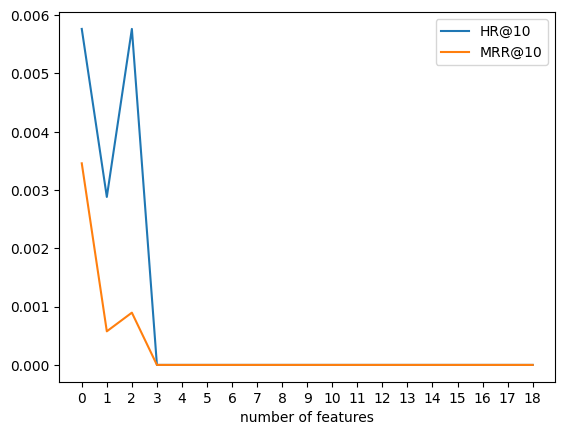

In [57]:
# Hypothesis 4
Z5 = cosine_similarity(cosine_similarity(item_features_mtx.T) @ A.T)
np.fill_diagonal(Z5, 0)

# U5, s5 = hsvd(item_features_mtx, rank = 17, right_similarity=Z5, beta = beta, ret='left')
S_I = (1 - beta) * np.eye(Z5.shape[0]) + beta * Z5
L_I = cholesky(S_I)
R_ = item_features_mtx @ L_I
U5, V, m, n = SVD(R_, 18, 1e-3, 0.1, 200) 

importance5, _ = maxvol_rect(U5[:-1,:].T, dr_min=1)
hr5, mrr5, cov5 = test_hypo(config1, importance5)

plt.plot(hr5,label='HR@10')
plt.plot(mrr5, label='MRR@10')
plt.xlabel('number of features')
plt.xticks(np.arange(0, len(importance5)+1))
# plt.yticks(np.arange(0, 0.007, 0.0008))
plt.legend()

100%|██████████| 18/18 [07:51<00:00, 26.20s/it]


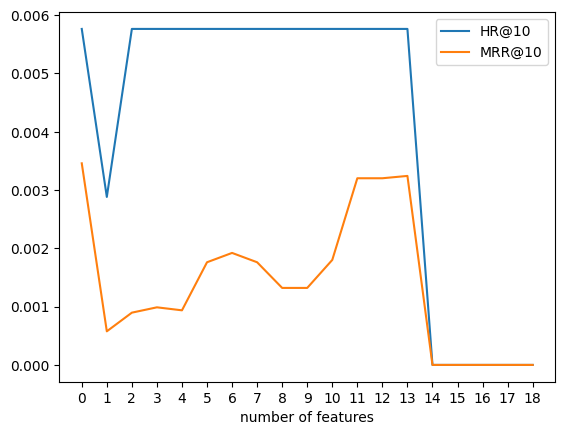

In [81]:
# Hypothesis 5
Z6 = cosine_similarity(A.T @ cosine_similarity(user_features_mtx))
np.fill_diagonal(Z6, 0)

# U5, s5 = hsvd(item_features_mtx, rank = 17, right_similarity=Z5, beta = beta, ret='left')
S_I = (1 - beta) * np.eye(Z6.shape[0]) + beta * Z6
L_I = cholesky(S_I)
R_ = item_features_mtx @ L_I
U6, V, m, n = SVD(R_, 18, 1e-3, 0.1, 200) 

importance6, _ = maxvol_rect(U6[:-1,:].T, dr_min=1)
hr6, mrr6, cov6 = test_hypo(config1, importance6)

plt.plot(hr6,label='HR@10')
plt.plot(mrr6, label='MRR@10')
plt.xlabel('number of features')
plt.xticks(np.arange(0, len(importance6)+1))
# plt.yticks(np.arange(0, 0.007, 0.0008))
plt.legend()